In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
prices = pd.read_csv('../../data/Ames_Housing_Price_Data.csv',index_col = 0)
estate = pd.read_csv('../../data/Ames_Real_Estate_Data.csv')

/Users/pizac/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (36,40,81,87) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
prices['YrSold'].value_counts()

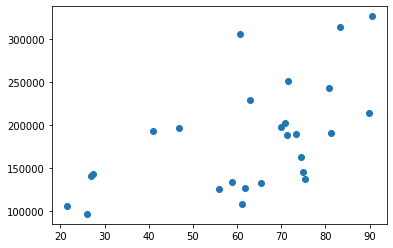

In [2]:
boro = prices.groupby('Neighborhood')[['LotFrontage','SalePrice']].mean().reset_index().sort_values(by = 'SalePrice')
#corr = .55 between LotFrontage and SalePrice
plt.scatter(boro.LotFrontage,boro.SalePrice)

In [ ]:
print(prices['LotFrontage'].mean())
print(prices['LotFrontage'].std())

In [3]:
new_prices = prices.copy()
new_prices = new_prices.loc[~new_prices['Neighborhood'].isin(['Landmrk','Greens','GrnHill'])]

In [10]:
na_col = new_prices.isnull().sum()
na_col[na_col>0]

Alley           2401
MasVnrType        14
MasVnrArea        14
BsmtQual          68
BsmtCond          68
BsmtExposure      70
BsmtFinType1      68
BsmtFinSF1         1
BsmtFinType2      69
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
FireplaceQu     1239
GarageType       127
GarageYrBlt      129
GarageFinish     129
GarageCars         1
GarageArea         1
GarageQual       129
GarageCond       129
PoolQC          2560
Fence           2045
MiscFeature     2472
dtype: int64

In [ ]:
def check_frontage(boro):
    x = prices['LotFrontage'].loc[prices['Neighborhood']==boro]
    return plt.hist(x)

In [ ]:
check_frontage('Sawyer')

## Reducing to numeric features

In [11]:
new_prices['LotFrontage'] = new_prices['LotFrontage'].fillna(new_prices.groupby('Neighborhood')['LotFrontage'].transform('mean'))

In [33]:
import numpy as np
numeric_features = new_prices.select_dtypes(include = np.number)
print(numeric_features.isnull().sum())


numeric_features_filled = numeric_features.apply(lambda x: x.fillna(x.mean()))
y_price = numeric_features_filled['SalePrice']
numeric_features_filled.drop(['PID','SalePrice'], axis = 1, inplace = True)

PID                0
GrLivArea          0
SalePrice          0
MSSubClass         0
LotFrontage        0
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea        14
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
BsmtFullBath       2
BsmtHalfBath       2
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt      129
GarageCars         1
GarageArea         1
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
dtype: int64


In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data['feature'] = numeric_features_filled.columns
vif_data['VIF'] = [variance_inflation_factor(numeric_features_filled.values, i) for i in range(len(numeric_features_filled.columns))]

/Users/pizac/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [141]:
vif_data[vif_data['VIF']>=5]

,feature,VIF
0,GrLivArea,inf
2,LotFrontage,1.982057e+01
4,OverallQual,6.212174e+01
5,OverallCond,4.120063e+01
6,YearBuilt,2.064884e+04
7,YearRemodAdd,2.144999e+04
9,BsmtFinSF1,inf
10,BsmtFinSF2,inf
11,BsmtUnfSF,inf
12,TotalBsmtSF,inf


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

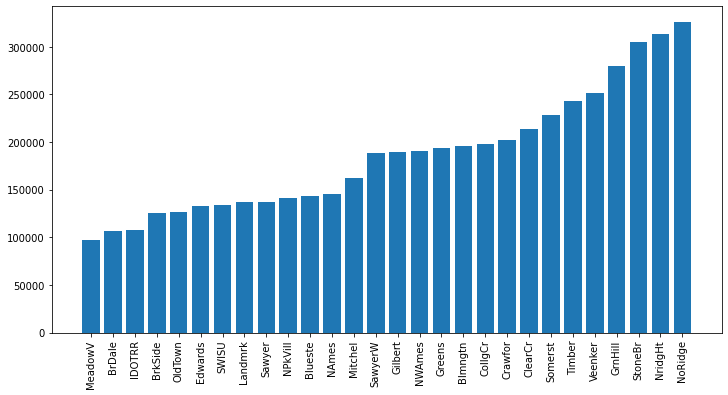

In [24]:
boro = prices.groupby('Neighborhood')[['SalePrice']].mean()
boro = boro.reset_index().sort_values(by = 'SalePrice')
import matplotlib.pyplot as plt
plt.figure(figsize = (12,6))
plt.bar(x = boro.Neighborhood, height = boro.SalePrice)
plt.xticks(rotation = 90)

<AxesSubplot:>

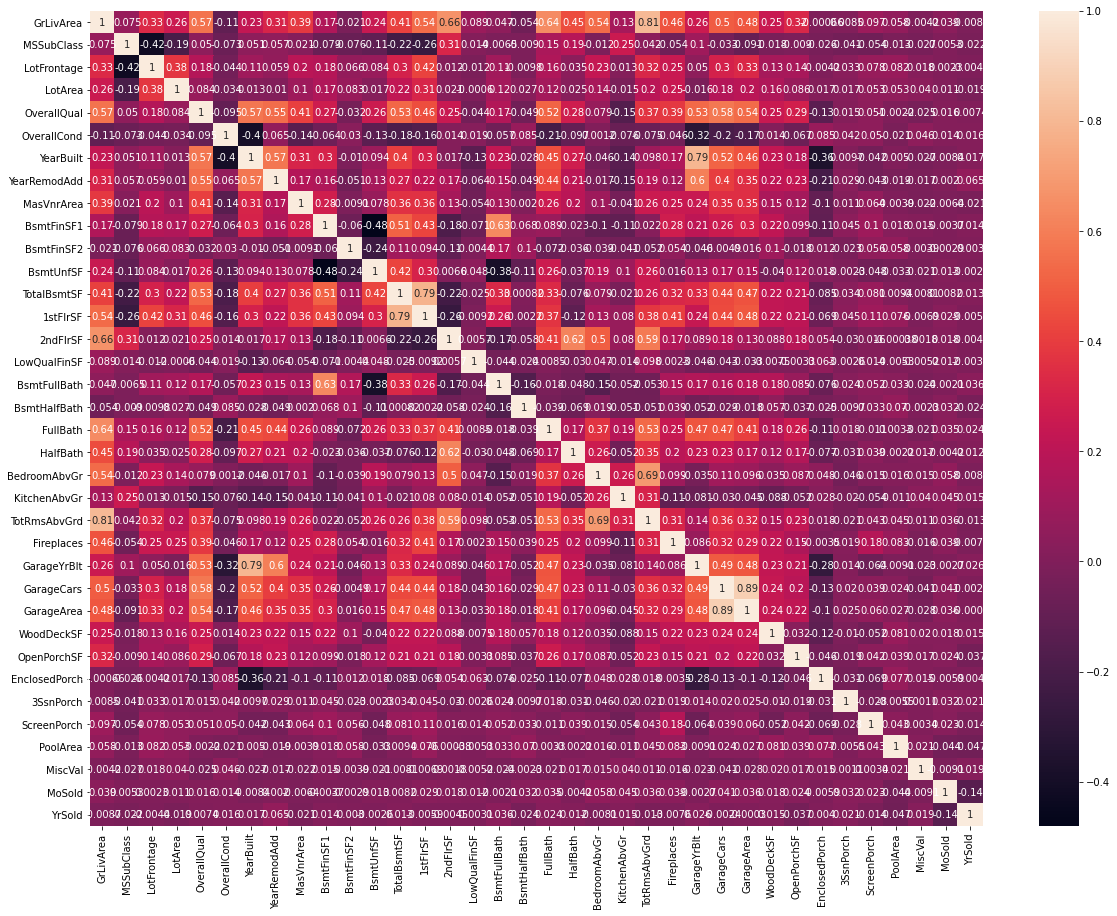

In [25]:
plt.figure(figsize = (20,15))
sns.heatmap(numeric_features_filled.corr(), annot = True)

In [145]:
r_prices = new_prices.corr()
r_prices = r_prices[['SalePrice']][1:]


<AxesSubplot:>

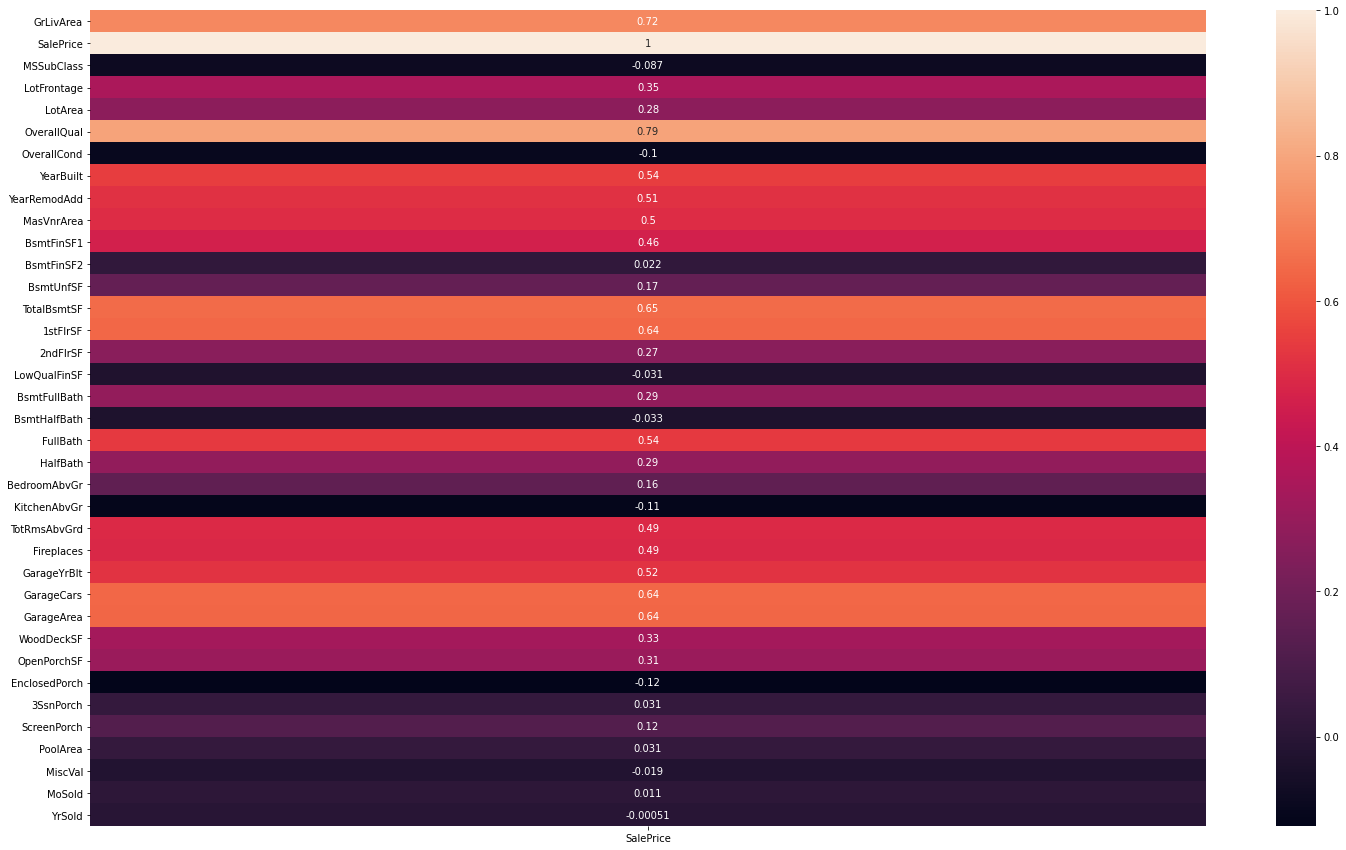

In [146]:
plt.figure(figsize = (25,15))
sns.heatmap(r_prices,annot = True)

In [149]:
prices.loc[prices.Electrical.isna()]

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
626,916386080,1394,167500,80,RL,73.0,9735,Pave,NaN,Reg,...,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal


Median is 159900.0
Mean is 178059.62325581396


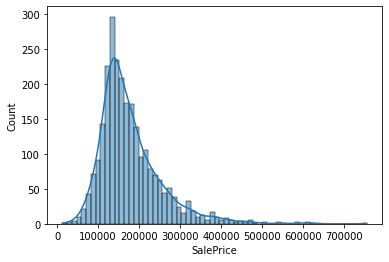

In [148]:
sns.histplot(new_prices.SalePrice,kde = True)
print(f'Median is {np.median(prices.SalePrice)}')
print(f'Mean is {np.mean(prices.SalePrice)}')

<AxesSubplot:xlabel='BsmtCond', ylabel='SalePrice'>

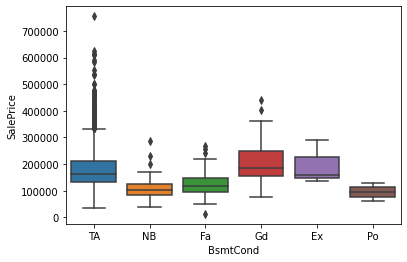

In [29]:
prices.BsmtCond.fillna('NB', inplace = True)
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(data = prices, x = 'BsmtCond',y = 'SalePrice')

In [ ]:
from scipy import stats
stats.f_oneway()

In [ ]:
prices['Electrical'].value_counts()

### Impute mean to get quick linear regression

<p> Gabi says drop garagecars, garagequal and garagecondition</p>

In [ ]:
#Keep garage finish, type, area

In [151]:
from sklearn.linear_model import Lasso
lasso = Lasso(max_iter = 100000)


from sklearn.model_selection import cross_validate
alphas = np.linspace(.0001,10,500)

cv_res=[]

for alpha in alphas:
    lasso.set_params(normalize = True,alpha = alpha)
    cv_res.append(cross_validate(lasso, numeric_features_filled, y_price, cv = 5, return_train_score = True))

/Users/pizac/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34398319546.67944, tolerance: 1089620948.3723369
  positive)
/Users/pizac/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41450808121.59387, tolerance: 1092762490.7612643
  positive)
/Users/pizac/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50408126503.93335, tolerance: 1187020597.728053
  positive)
/Users/pizac/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Obje

In [152]:
lasso_test = [i['test_score'].mean() for i in cv_res]
lasso_train = [i['train_score'].mean() for i in cv_res]

In [153]:
alpha_ind = lasso_test.index(max(lasso_test))

In [154]:
f'alpha: {alphas[alpha_ind]}, train_score: {lasso_train[alpha_ind]}, test_score: {lasso_test[alpha_ind]}'

'alpha: 6.5731805611222445, train_score: 0.870277486819961, test_score: 0.8645636857160701'

In [155]:
lasso.set_params(normalize = True,alpha = alphas[alpha_ind])
test = lasso.fit(numeric_features_filled,y_price)

In [156]:
for col, coef in zip(numeric_features_filled.columns, test.coef_):
    print(f'{col}:   {coef}')

GrLivArea:   58.44314597781667
MSSubClass:   -119.36914452544795
LotFrontage:   63.05376541050299
LotArea:   0.49874764723979176
OverallQual:   15290.29729934294
OverallCond:   3870.4583359466096
YearBuilt:   228.5711713765043
YearRemodAdd:   194.68095984819104
MasVnrArea:   32.202079717921855
BsmtFinSF1:   20.555777930426107
BsmtFinSF2:   4.608574134684831
BsmtUnfSF:   -0.0
TotalBsmtSF:   19.7727060478688
1stFlrSF:   0.21000546899626232
2ndFlrSF:   0.0
LowQualFinSF:   -20.29389507787189
BsmtFullBath:   2980.1133572714552
BsmtHalfBath:   -0.0
FullBath:   -0.0
HalfBath:   -0.0
BedroomAbvGr:   -9573.778930812605
KitchenAbvGr:   -9739.481085022204
TotRmsAbvGrd:   1971.08104066642
Fireplaces:   3817.662130654632
GarageYrBlt:   139.5403813555028
GarageCars:   170.3171624926543
GarageArea:   24.46289278519262
WoodDeckSF:   10.333418296494031
OpenPorchSF:   -1.201254075719411
EnclosedPorch:   8.003600561239802
3SsnPorch:   -0.0
ScreenPorch:   35.73227084316165
PoolArea:   -4.368663097687111
M

In [140]:
ols = LinearRegression()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(numeric_features_filled,y_price,test_size=0.2,random_state = 42)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
ols.fit(X_train,y_train)
print(f'MLR training score: {ols.score(X_train,y_train)}')
print(f'MLR testing score: {ols.score(X_test,y_test)}')



lasso.set_params(normalize = True,alpha = alphas[alpha_ind])
lasso.fit(X_train,y_train)
print(f'Lasso training score: {lasso.score(X_train,y_train)}')
print(f'Lasso testing score: {lasso.score(X_test,y_test)}')

MLR training score: 0.868630066211588
MLR testing score: 0.8705673695830202
Lasso training score: 0.8680521963664783
Lasso testing score: 0.8700619409316851


In [109]:
for col, coef in zip(numeric_features_filled.columns, lasso.coef_):
    print(f'{col}:   {coef}')

GrLivArea:   54.696309158625915
MSSubClass:   -113.30360281325375
LotFrontage:   28.572475541063064
LotArea:   0.685193334274785
OverallQual:   15768.16573102935
OverallCond:   3913.8654548681366
YearBuilt:   235.41872437871322
YearRemodAdd:   210.4881607773487
MasVnrArea:   28.06219012641531
BsmtFinSF1:   18.839025629069262
BsmtFinSF2:   5.2507196139228
BsmtUnfSF:   -0.0
TotalBsmtSF:   20.077362088797955
1stFlrSF:   0.0
2ndFlrSF:   0.0
LowQualFinSF:   -16.16241211945144
BsmtFullBath:   4025.2270853173145
BsmtHalfBath:   -0.0
FullBath:   -0.0
HalfBath:   -0.0
BedroomAbvGr:   -9426.992668378442
KitchenAbvGr:   -8776.749344245522
TotRmsAbvGrd:   2420.8900471981956
Fireplaces:   3914.5538798383204
GarageYrBlt:   127.9957388766303
GarageCars:   0.0
GarageArea:   28.959522929530017
WoodDeckSF:   8.498294017402163
OpenPorchSF:   -6.306417196251449
EnclosedPorch:   10.34933864411306
3SsnPorch:   -0.0
ScreenPorch:   37.587555409437144
PoolArea:   -0.0
MiscVal:   -0.45086035983380623
MoSold:   

# Drop Features Post-lasso

In [116]:
post_lasso = numeric_features_filled.drop(['BsmtUnfSF','2ndFlrSF','BsmtHalfBath','GarageCars','3SsnPorch','PoolArea'],axis = 1)

In [137]:
X_train, X_test, y_train, y_test = train_test_split(post_lasso,y_price,test_size=0.2,random_state = 42)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [138]:
ols2 = LinearRegression()
ols2.fit(X_train,y_train)
print(ols2.score(X_train,y_train))
print(ols2.score(X_test,y_test))

0.8686042047170779
0.8704064681699919
